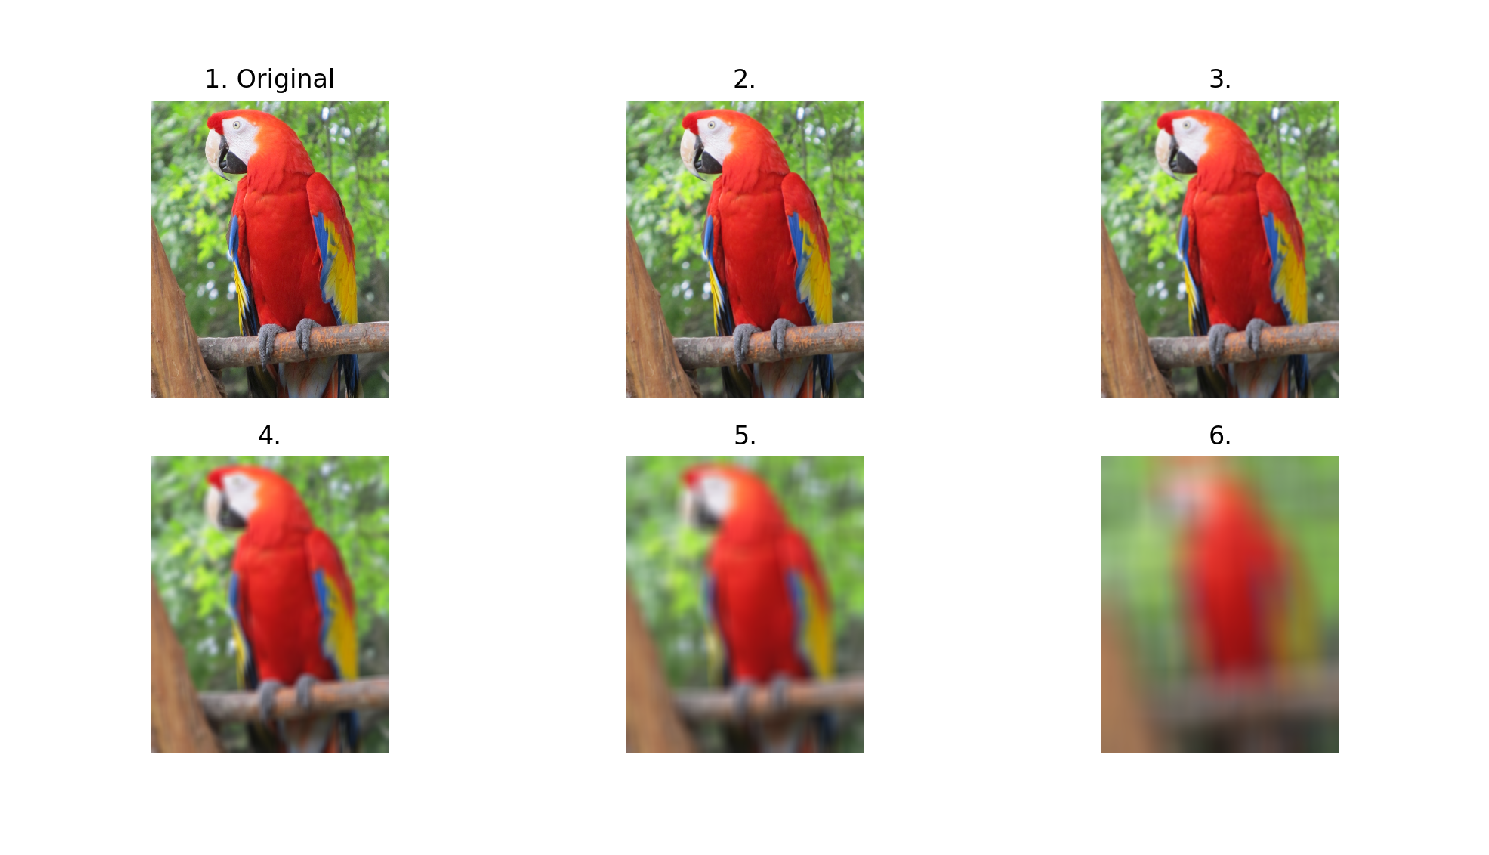

In [3]:
import os
import io
import cv2

import numpy as np
import matplotlib.pyplot as plt

READTHEDOCS_TEMPLATE_ALBU = (
    "[{name}](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations"
)
READTHEDOCS_TEMPLATE_IMGAUG = "[{name}](https://albumentations.readthedocs.io/en/latest/api/imgaug.html#albumentations"
TRANSFORM_NAME_WITH_LINK_TEMPLATE = READTHEDOCS_TEMPLATE_ALBU + ".augmentations.transforms.{name})"
IMGAUG_TRANSFORM_NAME_WITH_LINK_TEMPLATE = READTHEDOCS_TEMPLATE_IMGAUG + ".imgaug.transforms.{name})"


def load_rgb_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def get_figure(height=1080, width=1920, dpi=200):
    return plt.figure(figsize=(width / dpi, height / dpi))


def figure_to_numpy(figure, dpi=200):
    buf = io.BytesIO()
    figure.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    image = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def apply_transform(
        image, transform_cls, args, targets=None, nrows=None, ncols=None, height=1080, width=1920, dpi=200
):

    args = [{"p": 0}] + list(args)
    targets = targets or {}
    total = len(args)

    if nrows is None:
        nrows = total // np.sqrt(total).astype(int)
    if ncols is None:
        ncols = total // nrows

    if nrows * ncols != total:
        ncols += 1

    nrows, ncols = min(nrows, ncols), max(nrows, ncols)

    result_args = []
    figure = get_figure(height, width, dpi)
    figure.tight_layout(pad=0)
    for i, args_i in enumerate(args, 1):
        if "p" not in args_i:
            args_i["p"] = 1

        if i == 1:
            title = f"{i}. Original"
        else:
            title = f"{i}."

        ax = figure.add_subplot(nrows, ncols, i)
        ax.set_title(title)
        ax.axis("off")
        ax.imshow(transform_cls(**args_i)(image=image, **targets)["image"])

        result_args.append(args_i)

    figure.canvas.draw()
    plt.axis("off")
    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.1, top=0.9, hspace=0.2, wspace=0.01)
    result_image = figure_to_numpy(figure, dpi)
    plt.close(figure)

    return result_args, result_image


def create_docs_text(cls, args):
    name = cls.__name__
    module = cls.__module__

    docs_link = None
    if module == "albumentations.augmentations.transforms":
        docs_link = TRANSFORM_NAME_WITH_LINK_TEMPLATE.format(name=name)
    elif cls.__module__ == "albumentations.imgaug.transforms":
        docs_link = IMGAUG_TRANSFORM_NAME_WITH_LINK_TEMPLATE.format(name=name)

    text = f"[{name}]({docs_link})\n" + "-" * len(name) + "\n\n"

    for i, args_i in enumerate(args, 1):
        if args_i["p"] == 0:
            text += f"{i}. Original image\n"
            continue
        args_i = ", ".join(f"{key}={value}" for key, value in args_i.items())
        text += f"{i}. `{name}({args_i})`\n"

    text += f"\n![{name} image](images/augs_examples/{name}.jpg)\n"

    return text


def show_image(image, dpi=200):
    plt.figure(figsize=(1920 / dpi, 1080 / dpi), dpi=dpi)
    plt.imshow(image)
    plt.axis("off")
    plt.show()


def save_results(cls, text, image, save_path):
    with open(save_path, "a") as file:
        file.write("\n\n" + text)

    image_path = os.path.split(save_path)[0]
    image_path = os.path.join(image_path, f"images/augs_examples/{cls.__name__}.jpg")
    cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))


def create_example(
        transform_cls, args, image_path, targets=None, nrows=None, ncols=None, height=1080, width=1920, dpi=200
):
    image = load_rgb_image(image_path)

    args, image = apply_transform(
        image=image,
        transform_cls=transform_cls,
        args=args,
        targets=targets,
        nrows=nrows,
        ncols=ncols,
        height=height,
        width=width,
        dpi=dpi,
    )
    text = create_docs_text(transform_cls, args)

    return text, image


def create_and_save(
        save_path,
        transform_cls,
        args,
        image_path,
        targets=None,
        nrows=None,
        ncols=None,
        height=1080,
        width=1920,
        dpi=200,
        show=True,
):
    text, image = create_example(
        transform_cls, args, image_path, targets=targets, nrows=nrows, ncols=ncols, height=height, width=width, dpi=dpi
    )

    save_results(transform_cls, text, image, save_path)

    if show:
        show_image(image, dpi=dpi)


if __name__ == "__main__":
    import albumentations as A

#     save_path = "../README.md"
#     image_path = "../images/original_parrot.jpg"
    save_path = '/home/manhduy/Documents/model_DL/envData_Augmentation/data_augmentation/images/created_image/README.md'
    image_path = '/home/manhduy/Documents/model_DL/envData_Augmentation/data_augmentation/images/parrot.jpg'
    
    transform = A.Blur
    args = [
        {'blur_limit': (7, 7)},
        {'blur_limit': (15, 15)},
        {'blur_limit': (50, 50)},
        {'blur_limit': (100, 100)},
        {'blur_limit': (300, 300)},
    ]

    create_and_save(save_path, transform, args, image_path)


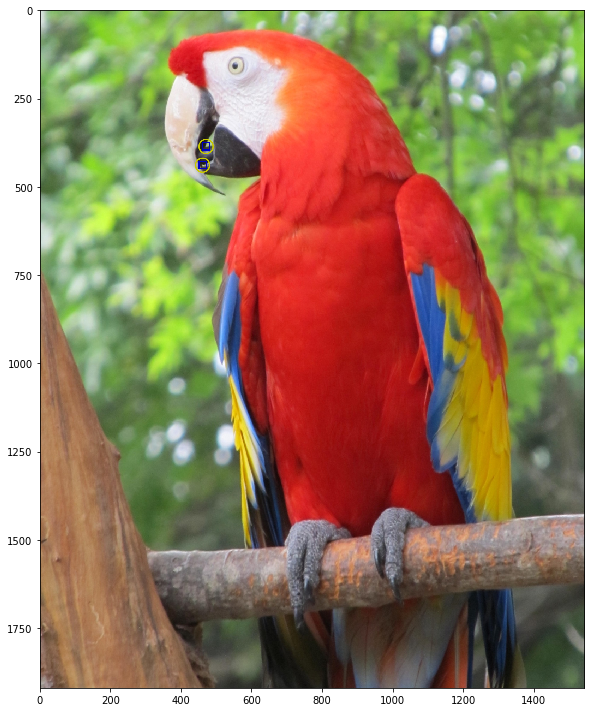

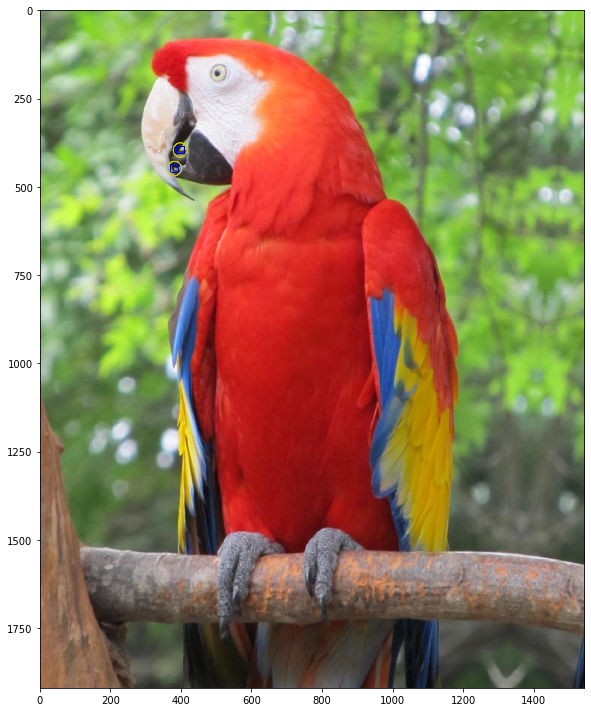

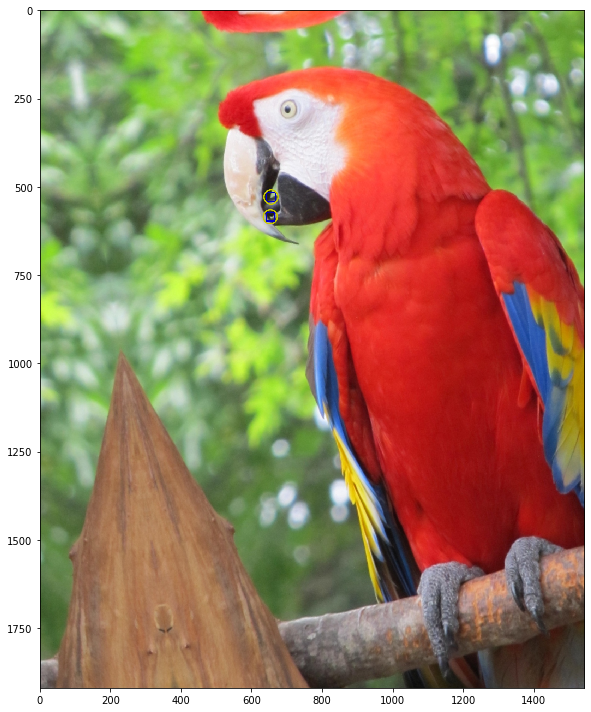

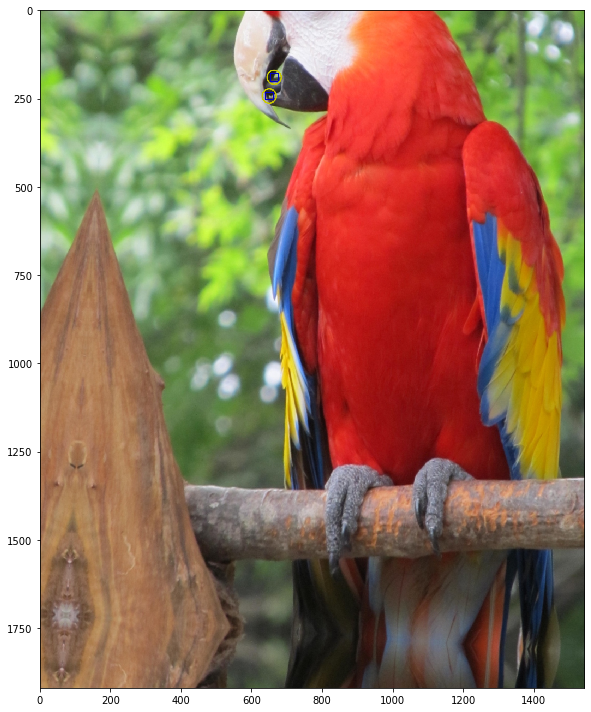

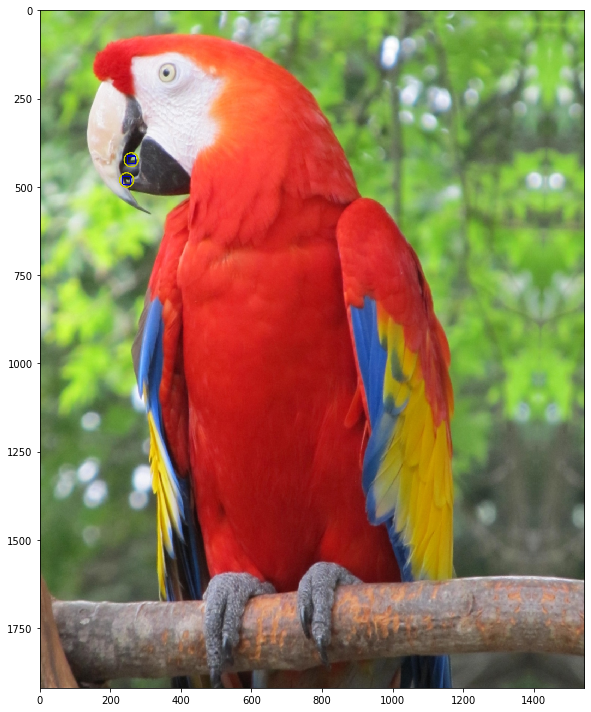

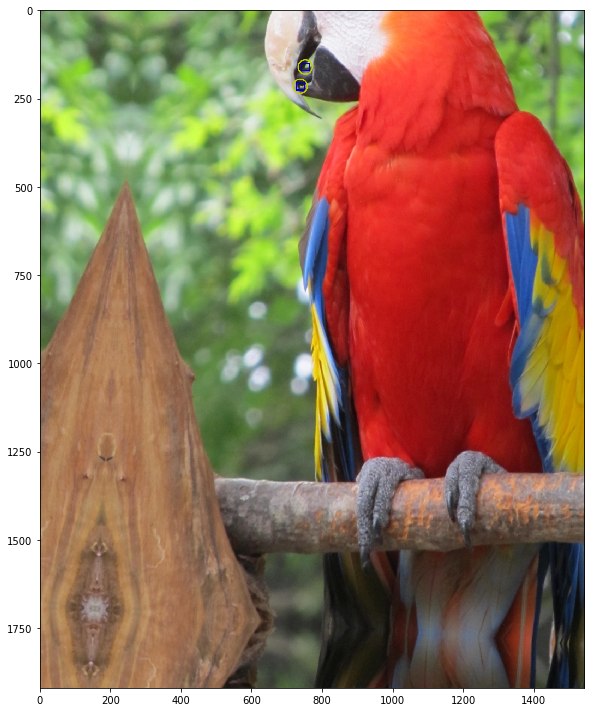

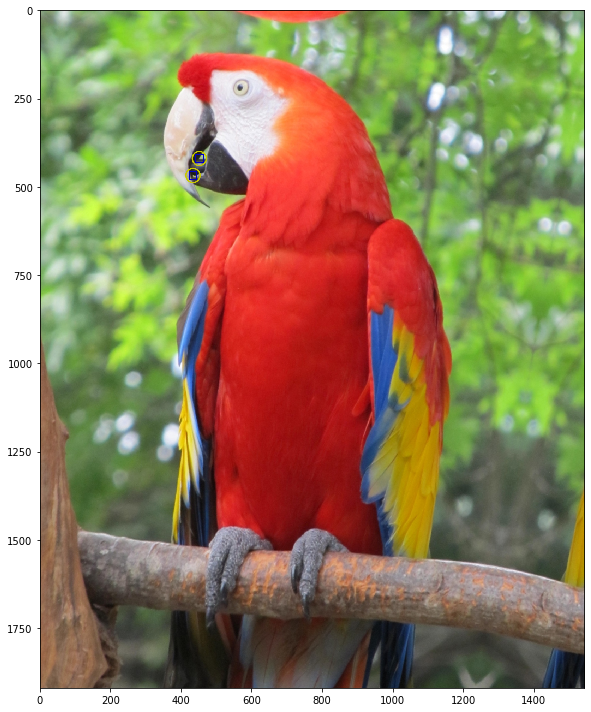

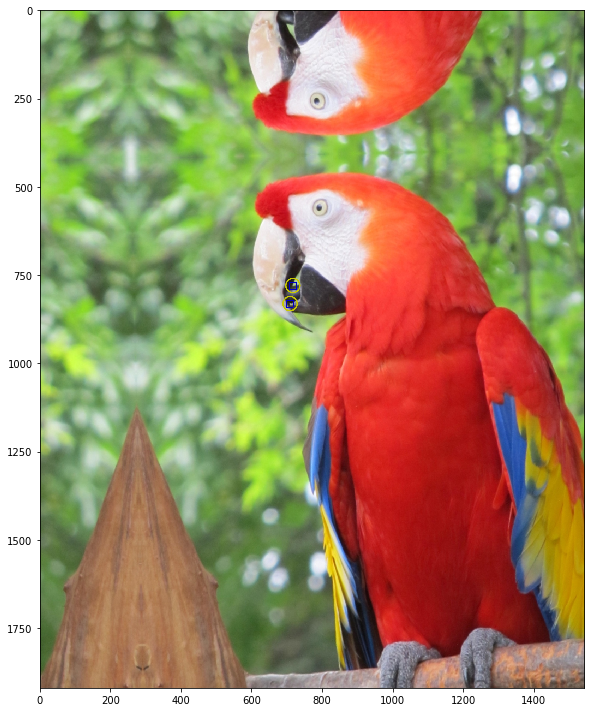

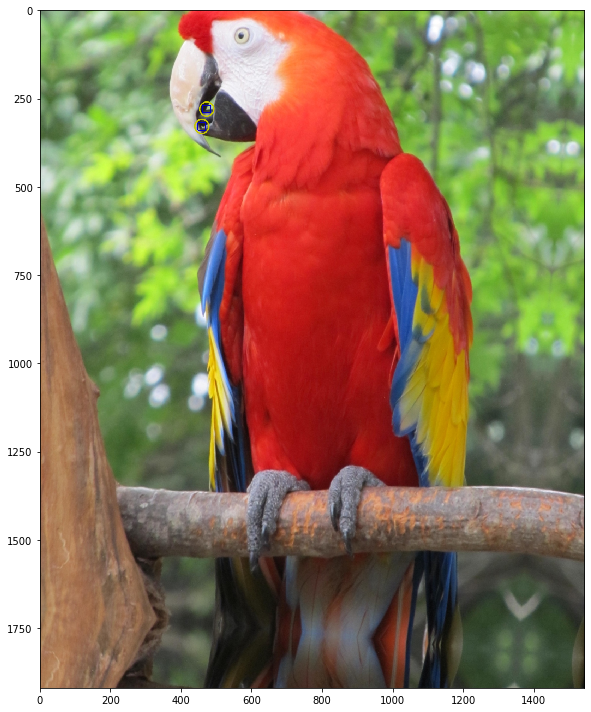

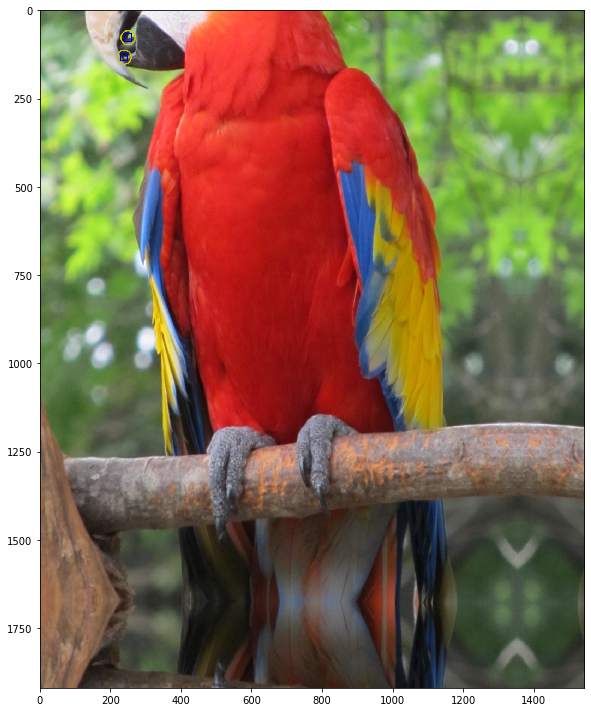

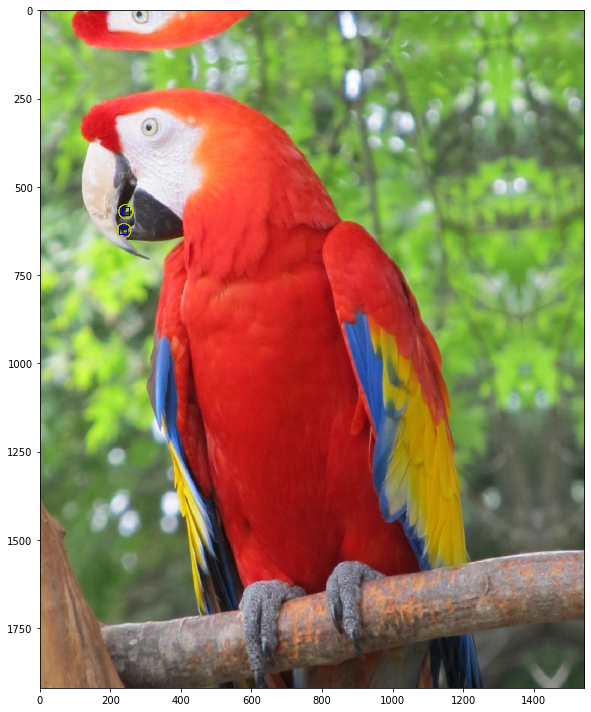

In [4]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt


def visualize(image, keypoints, bboxes):
    overlay = image.copy()
    for kp in keypoints:
        cv2.circle(overlay, (int(kp[0]), int(kp[1])), 20, (0, 200, 200), thickness=2, lineType=cv2.LINE_AA)

    for box in bboxes:
        cv2.rectangle(overlay, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (200, 0, 0), thickness=2)

    return overlay

image_path = '/home/manhduy/Documents/model_DL/envData_Augmentation/data_augmentation/images/parrot.jpg'


def main():
    image = cv2.imread(image_path)

    keypoints = cv2.goodFeaturesToTrack(
        cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), maxCorners=100, qualityLevel=0.5, minDistance=5
    ).squeeze(1)

    bboxes = [(kp[0] - 10, kp[1] - 10, kp[0] + 10, kp[1] + 10) for kp in keypoints]

    disp_image = visualize(image, keypoints, bboxes)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(disp_image, cv2.COLOR_RGB2BGR))
    plt.tight_layout()
    plt.show()

    aug = A.Compose(
        [A.ShiftScaleRotate(scale_limit=0.1, shift_limit=0.2, rotate_limit=10, always_apply=True)],
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["bbox_labels"]),
        keypoint_params=A.KeypointParams(format="xy"),
    )

    for _i in range(10):
        data = aug(image=image, keypoints=keypoints, bboxes=bboxes, bbox_labels=np.ones(len(bboxes)))

        aug_image = data["image"]
        aug_image = visualize(aug_image, data["keypoints"], data["bboxes"])

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    main()